# DL Model Fit with Validation (Transformer)
* Test several loss functions and optimizers
* Use several metrics to compare
* Test on last data point
* Visualize loss and metrics
* Evaluate and predict on train set to try to foresee the result

__If any single HP has to be tuned, this should be the learning rate__. Good articles about learning rate:  
a) Theory: https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/  
b) Practice: https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/   
FINDING THE RIGHT LEARNING SHOULD A WHOLE SEPARATE EXPERIMENT OF ITS OWN

In [6]:
from keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model, model_to_dot
import pydot as pyd
keras.utils.vis_utils.pydot = pyd


from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import time
import random
import pickle as pkl
import keras
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Bidirectional, LSTM, Dropout, ConvLSTM2D, Flatten, TimeDistributed, RepeatVector
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adamax, Adam, Nadam, Ftrl
from keras.callbacks import LearningRateScheduler, EarlyStopping
from helper import ( prepare_data, train_test_shuffle_split, train_test_seq_split, print_folds_stats )
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error as mse

from matplotlib import pyplot as plt
plt.style.use('ggplot')     # 'fivethirtyeight'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# LOSSES
mse     = tf.keras.losses.MeanSquaredError()
mae     = tf.keras.losses.MeanAbsoluteError()
mape    = tf.keras.losses.MeanAbsolutePercentageError()
msle    = tf.keras.losses.MeanSquaredLogarithmicError()        # square(log(y_true + 1.) - log(y_pred + 1.))
huber   = tf.keras.losses.Huber()
logcosh = tf.keras.losses.LogCosh()

# METRICS
metric_mse   = tf.keras.metrics.MeanSquaredError()
metric_rmse  = tf.keras.metrics.RootMeanSquaredError()
metric_mae   = tf.keras.metrics.MeanAbsoluteError()
metric_mape  = tf.keras.metrics.MeanAbsolutePercentageError()
metric_msle  = tf.keras.metrics.MeanSquaredLogarithmicError()
metric_lcosh = tf.keras.metrics.LogCoshError()

In [8]:
# THESE GUYS SUPPOSEDLY HAVE IN-BUILT ADAPTIVE LRs
# IT IS RECOMMENDED TO KEEP THE DEFAULT HYPERPARAMETERS UNCHANGED (I saw confirmations of this with lower starting
# error scores for RMSprop)
# Adam is improved RMSprop which is improved Adadelta which is improved Adagrad (latter - aggressive adaptive decay)
# More details: https://keras.io/api/optimizers/

#keras.optimizers.Adagrad(  lr=0.01,  epsilon=1e-08, decay=0.0 )
#keras.optimizers.Adadelta( lr=1.0,   rho=0.95,      epsilon=1e-08, decay=0.0 )
#keras.optimizers.RMSprop(  lr=0.001, rho=0.9,       epsilon=1e-08, decay=0.0 )
#keras.optimizers.Adam(     lr=0.001, beta_1=0.9,    beta_2=0.999,  epsilon=1e-08, decay=0.0 )

In [9]:
# PREDICT ON ONE DATA POINT
def predict_one(model, X_last, loss_func=mse):
       
    X_last = X_last.reshape((1, n_steps, n_features))
    pred = model.predict(X_last, verbose=0)
    return np.round( pred[0] )

## Prepare data

In [10]:
df = pd.read_csv( 'data/2step_20210329.csv', encoding='utf-8' )
print('Shape of loaded data:', df.shape, '\n')

random_state      = 34
n_steps           = 10
features          = ['num1', 'num2', 'num3', 'num4']
n_features        = len(features)
n_output_features = len(features)
with_intersection = True
flatten           = False

( X,
  y,
  goldenx,
  goldeny )  = prepare_data( df,
                             features,
                             n_steps,
                             with_intersection=with_intersection,
                             flatten=flatten )

X_sh, y_sh = deepcopy(X), deepcopy(y)
X_sh, y_sh = shuffle( X_sh, y_sh, random_state=random_state, n_samples=None )

# shape changes to [1, n_features * n_step], but still need to keep n_output_features for output layer
if flatten:
    n_features = n_features * n_steps
    n_steps    = 1
    X = X.reshape(X.shape[0], n_steps, n_features)
    X_sh = X_sh.reshape(X.shape[0], n_steps, n_features)

Shape of loaded data: (2073, 8) 

Dropping 1 last row for golden data point
Data prepared:
	Size of X = (2062 by 10)
	Size of y = (2062 by 4)


In [11]:
# review data
idx = 1
print(f'X[{idx}]:', X[idx])
print(f'y[{idx}]:', y[idx])
df.head(25)

X[1]: [[30 34 23  4]
 [ 3 29 18 33]
 [23 35 28 17]
 [16 11 28  4]
 [32  4 28 34]
 [ 4  3 33  2]
 [21 10 31  6]
 [ 7 24 25 20]
 [30 25 16 23]
 [21 20 31  8]]
y[1]: [23  3 17 28]


,m,d,y,num1,num2,num3,num4,b
0,5,18,2001,9,10,22,13,1
1,5,22,2001,30,34,23,4,13
2,5,25,2001,3,29,18,33,17
3,5,29,2001,23,35,28,17,20
4,6,1,2001,16,11,28,4,31
5,6,5,2001,32,4,28,34,20
6,6,8,2001,4,3,33,2,29
7,6,12,2001,21,10,31,6,21
8,6,15,2001,7,24,25,20,35
9,6,19,2001,30,25,16,23,25


In [12]:
print(X.shape)
print(y.shape)

(2062, 10, 4)
(2062, 4)


## Create model
https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb  
Note: there is some data preparation done in the beginning. __Relevant__?

## Part 1. Simple LSTM
best result:
epochs        = 250
n_hidden      = 100
learning_rate = 0.001
es            = EarlyStopping( monitor='loss', mode='min', patience=50 )
activation    = 'elu'
opt           = Adam(lr=learning_rate)#, clipnorm=1)

In [126]:
epochs        = 250
n_hidden      = 100
learning_rate = 0.001
es            = EarlyStopping( monitor='loss', mode='min', patience=50 )
activation    = 'elu'
opt           = Adam(lr=learning_rate)#, clipnorm=1)

input_train = Input(shape=(X.shape[1], X.shape[2]))
output_train = Input(shape=(y.shape[1], 1))

In [127]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation=activation, dropout=0.2, recurrent_dropout=0, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

Tensor("lstm_18/Identity:0", shape=(None, 100), dtype=float32)
Tensor("lstm_18/Identity_1:0", shape=(None, 100), dtype=float32)
Tensor("lstm_18/Identity_2:0", shape=(None, 100), dtype=float32)


In [128]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [129]:
decoder = RepeatVector(y.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation=activation, dropout=0.2, recurrent_dropout=0, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

Tensor("lstm_19/Identity:0", shape=(None, 4, 100), dtype=float32)


In [130]:
out = TimeDistributed(Dense(1))(decoder)
print(out)

Tensor("time_distributed_9/Identity:0", shape=(None, 4, 1), dtype=float32)


In [131]:
model = Model(inputs=input_train, outputs=out)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
lstm_18 (LSTM)                  [(None, 100), (None, 42000       input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 100)          400         lstm_18[0][0]                    
__________________________________________________________________________________________________
repeat_vector_10 (RepeatVector) (None, 4, 100)       0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

In [132]:
history = model.fit(X, y, validation_split=0.25, 
                    epochs=epochs, verbose=1, callbacks=[es], 
                    batch_size=32)

Epoch 1/250
49/49 [==============================] - 2s 41ms/step - loss: 257.1178 - mae: 13.1991 - val_loss: 140.9627 - val_mae: 9.7517
Epoch 2/250
49/49 [==============================] - 1s 29ms/step - loss: 123.0559 - mae: 9.3746 - val_loss: 112.5370 - val_mae: 9.0031
Epoch 3/250
49/49 [==============================] - 2s 32ms/step - loss: 110.4242 - mae: 9.0049 - val_loss: 109.8082 - val_mae: 8.9500
Epoch 4/250
49/49 [==============================] - 1s 27ms/step - loss: 108.5866 - mae: 8.9383 - val_loss: 106.4977 - val_mae: 8.8370
Epoch 5/250
49/49 [==============================] - 1s 22ms/step - loss: 106.8916 - mae: 8.8797 - val_loss: 106.8510 - val_mae: 8.8693
Epoch 6/250
49/49 [==============================] - 1s 25ms/step - loss: 106.3647 - mae: 8.8790 - val_loss: 105.3746 - val_mae: 8.8199
Epoch 7/250
49/49 [==============================] - 1s 29ms/step - loss: 105.9240 - mae: 8.8641 - val_loss: 105.0402 - val_mae: 8.8219
Epoch 8/250
49/49 [============================

Epoch 61/250
49/49 [==============================] - 1s 30ms/step - loss: 98.0604 - mae: 8.4989 - val_loss: 106.6648 - val_mae: 8.8710
Epoch 62/250
49/49 [==============================] - 2s 31ms/step - loss: 98.7045 - mae: 8.5309 - val_loss: 107.8462 - val_mae: 8.9046
Epoch 63/250
49/49 [==============================] - 2s 31ms/step - loss: 97.3627 - mae: 8.4777 - val_loss: 108.0747 - val_mae: 8.9239
Epoch 64/250
49/49 [==============================] - 1s 27ms/step - loss: 98.1528 - mae: 8.5027 - val_loss: 108.1922 - val_mae: 8.9201
Epoch 65/250
49/49 [==============================] - 1s 28ms/step - loss: 98.7418 - mae: 8.5259 - val_loss: 108.1347 - val_mae: 8.9047
Epoch 66/250
49/49 [==============================] - 1s 24ms/step - loss: 97.8136 - mae: 8.4826 - val_loss: 109.1110 - val_mae: 8.9356
Epoch 67/250
49/49 [==============================] - 1s 27ms/step - loss: 97.9061 - mae: 8.4923 - val_loss: 111.3326 - val_mae: 9.0268
Epoch 68/250
49/49 [============================

49/49 [==============================] - 1s 24ms/step - loss: 89.1723 - mae: 7.9883 - val_loss: 117.4815 - val_mae: 9.2346
Epoch 122/250
49/49 [==============================] - 1s 29ms/step - loss: 89.6421 - mae: 7.9937 - val_loss: 115.3156 - val_mae: 9.1587
Epoch 123/250
49/49 [==============================] - 1s 30ms/step - loss: 88.0458 - mae: 7.9398 - val_loss: 118.6053 - val_mae: 9.2350
Epoch 124/250
49/49 [==============================] - 1s 30ms/step - loss: 88.9556 - mae: 7.9650 - val_loss: 116.9853 - val_mae: 9.2032
Epoch 125/250
49/49 [==============================] - 1s 29ms/step - loss: 87.4203 - mae: 7.8915 - val_loss: 119.6473 - val_mae: 9.3240
Epoch 126/250
49/49 [==============================] - 2s 32ms/step - loss: 88.5694 - mae: 7.9366 - val_loss: 119.1675 - val_mae: 9.2946
Epoch 127/250
49/49 [==============================] - 1s 29ms/step - loss: 89.3947 - mae: 7.9935 - val_loss: 119.1832 - val_mae: 9.2840
Epoch 128/250
49/49 [==============================] - 

Epoch 181/250
49/49 [==============================] - 1s 28ms/step - loss: 78.6545 - mae: 7.3604 - val_loss: 121.5619 - val_mae: 9.3343
Epoch 182/250
49/49 [==============================] - 1s 30ms/step - loss: 80.2395 - mae: 7.4540 - val_loss: 120.8615 - val_mae: 9.2910
Epoch 183/250
49/49 [==============================] - 1s 30ms/step - loss: 79.1692 - mae: 7.3916 - val_loss: 121.4810 - val_mae: 9.3630
Epoch 184/250
49/49 [==============================] - 1s 29ms/step - loss: 78.1633 - mae: 7.3659 - val_loss: 125.4520 - val_mae: 9.4422
Epoch 185/250
49/49 [==============================] - 1s 28ms/step - loss: 78.2433 - mae: 7.3524 - val_loss: 121.0472 - val_mae: 9.3228
Epoch 186/250
49/49 [==============================] - 1s 29ms/step - loss: 76.0823 - mae: 7.2238 - val_loss: 124.3187 - val_mae: 9.3823
Epoch 187/250
49/49 [==============================] - 1s 27ms/step - loss: 78.0879 - mae: 7.3287 - val_loss: 125.1397 - val_mae: 9.4204
Epoch 188/250
49/49 [====================

Epoch 241/250
49/49 [==============================] - 1s 28ms/step - loss: 68.1835 - mae: 6.7673 - val_loss: 131.1106 - val_mae: 9.6360
Epoch 242/250
49/49 [==============================] - 1s 30ms/step - loss: 69.7423 - mae: 6.8211 - val_loss: 125.8749 - val_mae: 9.4576
Epoch 243/250
49/49 [==============================] - 1s 26ms/step - loss: 70.0591 - mae: 6.8215 - val_loss: 128.4062 - val_mae: 9.5033
Epoch 244/250
49/49 [==============================] - 2s 31ms/step - loss: 67.0286 - mae: 6.6949 - val_loss: 128.3133 - val_mae: 9.5458
Epoch 245/250
49/49 [==============================] - 1s 27ms/step - loss: 69.3272 - mae: 6.7891 - val_loss: 131.4285 - val_mae: 9.6103
Epoch 246/250
49/49 [==============================] - 1s 27ms/step - loss: 69.2992 - mae: 6.8255 - val_loss: 129.4509 - val_mae: 9.5615
Epoch 247/250
49/49 [==============================] - 2s 34ms/step - loss: 69.3560 - mae: 6.7850 - val_loss: 128.1416 - val_mae: 9.4848
Epoch 248/250
49/49 [====================

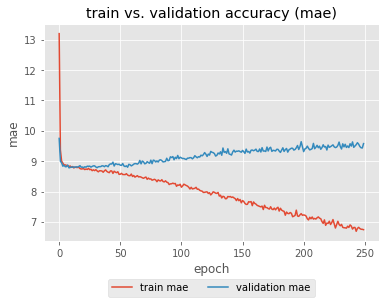

In [133]:
train_mae = history.history['mae']
valid_mae = history.history['val_mae'] 
#model.save('model_forecasting_seq2seq.h5')

plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [134]:
def predict_on_trainset( model, X_, y_ ):
    
    for feature_set, target in zip( X_, y_ ):
        print('True:     ', target)
        print('Predicted:', predict_one( model, feature_set ), '\n', '='*28, sep='')
                
        
# evaluate
print('Evaluating on train set...')
score = model.evaluate( X, y, verbose=1 )
print('\nTrain: ', score[0])
print('Train MSE:    ', score[1])

# predict
m = 100
print(f'Predicting on last {m} rows of train set:\n')
predict_on_trainset( model, X[-m:], y[-m:] )

Evaluating on train set...
65/65 [==============================] - 1s 9ms/step - loss: 63.3131 - mae: 6.2753

Train:  63.31311798095703
Train MSE:     6.275275707244873
Predicting on last 100 rows of train set:

True:      [19  5  4 28]
Predicted:[[21.]
 [21.]
 [17.]
 [18.]]
True:      [33 22  3 30]
Predicted:[[14.]
 [20.]
 [18.]
 [24.]]
True:      [23  2 18  3]
Predicted:[[21.]
 [12.]
 [18.]
 [16.]]
True:      [23  1 15 29]
Predicted:[[13.]
 [20.]
 [17.]
 [16.]]
True:      [10  7 18 33]
Predicted:[[17.]
 [10.]
 [17.]
 [17.]]
True:      [18 13  4 35]
Predicted:[[16.]
 [11.]
 [ 7.]
 [15.]]
True:      [27 11 13 32]
Predicted:[[10.]
 [24.]
 [ 9.]
 [14.]]
True:      [19 23  5 28]
Predicted:[[26.]
 [14.]
 [ 9.]
 [11.]]
True:      [23 24 17 34]
Predicted:[[21.]
 [19.]
 [ 9.]
 [21.]]
True:      [30 26  8 20]
Predicted:[[20.]
 [17.]
 [18.]
 [21.]]
True:      [ 8 30 11  3]
Predicted:[[10.]
 [17.]
 [ 8.]
 [19.]]
True:      [ 6 12 19  5]
Predicted:[[22.]
 [14.]
 [18.]
 [28.]]
True:      [31 18  

Predicted:[[19.]
 [19.]
 [12.]
 [15.]]
True:      [25 35  7 30]
Predicted:[[20.]
 [21.]
 [12.]
 [15.]]
True:      [13  2 26 24]
Predicted:[[20.]
 [11.]
 [22.]
 [32.]]
True:      [ 3 15 22 30]
Predicted:[[21.]
 [18.]
 [16.]
 [14.]]
True:      [30  3 11 19]
Predicted:[[20.]
 [28.]
 [14.]
 [13.]]
True:      [28  6  3 30]
Predicted:[[27.]
 [20.]
 [ 8.]
 [13.]]
True:      [ 8  9 28  3]
Predicted:[[18.]
 [23.]
 [10.]
 [13.]]
True:      [34 15 12 27]
Predicted:[[20.]
 [22.]
 [24.]
 [20.]]
True:      [ 7 29 22 26]
Predicted:[[19.]
 [24.]
 [20.]
 [14.]]
True:      [32  4 30  3]
Predicted:[[16.]
 [18.]
 [13.]
 [11.]]


In [136]:
model.optimizer

## LSTM with Attention

In [102]:
epochs        = 250
n_hidden      = 50
learning_rate = 0.001
es            = EarlyStopping( monitor='loss', mode='min', patience=50 )
activation    = 'relu'
opt           = Adamax(lr=learning_rate)#, clipnorm=1)

input_train = Input(shape=(X.shape[1], X.shape[2]))
output_train = Input(shape=(y.shape[1], 1))
print(input_train)
print(output_train)

Tensor("input_15:0", shape=(None, 10, 4), dtype=float32)
Tensor("input_16:0", shape=(None, 4, 1), dtype=float32)


In [103]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation=activation, dropout=0.2, recurrent_dropout=0, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

Tensor("lstm_14/Identity:0", shape=(None, 10, 50), dtype=float32)
Tensor("lstm_14/Identity_1:0", shape=(None, 50), dtype=float32)
Tensor("lstm_14/Identity_2:0", shape=(None, 50), dtype=float32)


In [104]:
#encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
#encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [105]:
decoder_input = RepeatVector(y.shape[1])(encoder_last_h)
print(decoder_input)

Tensor("repeat_vector_8/Identity:0", shape=(None, 4, 50), dtype=float32)


In [106]:
decoder_stack_h = LSTM(n_hidden, activation=activation, dropout=0.2, recurrent_dropout=0,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

Tensor("lstm_15/Identity:0", shape=(None, 4, 50), dtype=float32)


In [107]:
# ATTENTION LAYER
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

Tensor("activation_4/Identity:0", shape=(None, 4, 10), dtype=float32)


In [108]:
context = dot([attention, encoder_stack_h], axes=[2,1])
#context = BatchNormalization(momentum=0.8)(context)                 # originally 0.6
print(context)

Tensor("dot_9/Identity:0", shape=(None, 4, 50), dtype=float32)


In [109]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

Tensor("concatenate_4/Identity:0", shape=(None, 4, 100), dtype=float32)


In [110]:
out = TimeDistributed(Dense(1))(decoder_combined_context)
print(out)

Tensor("time_distributed_7/Identity:0", shape=(None, 4, 1), dtype=float32)


In [111]:
model = Model(inputs=input_train, outputs=out)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, 10, 50), (No 11000       input_15[0][0]                   
__________________________________________________________________________________________________
repeat_vector_8 (RepeatVector)  (None, 4, 50)        0           lstm_14[0][1]                    
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 4, 50)        20200       repeat_vector_8[0][0]            
                                                                 lstm_14[0][1]              

In [112]:
history = model.fit(X, y, validation_split=0.25, 
                    epochs=epochs, verbose=1, callbacks=[es], 
                    batch_size=32)

Epoch 1/250
49/49 [==============================] - 2s 48ms/step - loss: 166.6729 - mae: 10.5921 - val_loss: 112.6744 - val_mae: 9.0704
Epoch 2/250
49/49 [==============================] - 1s 28ms/step - loss: 120.6132 - mae: 9.2976 - val_loss: 113.1030 - val_mae: 9.0753
Epoch 3/250
49/49 [==============================] - 1s 27ms/step - loss: 116.8677 - mae: 9.2321 - val_loss: 109.4241 - val_mae: 8.9689
Epoch 4/250
49/49 [==============================] - 1s 30ms/step - loss: 114.4437 - mae: 9.1208 - val_loss: 111.2138 - val_mae: 9.0416
Epoch 5/250
49/49 [==============================] - 1s 24ms/step - loss: 111.4978 - mae: 9.0370 - val_loss: 112.0358 - val_mae: 9.0602
Epoch 6/250
49/49 [==============================] - 2s 31ms/step - loss: 110.5866 - mae: 8.9989 - val_loss: 110.6046 - val_mae: 9.0036
Epoch 7/250
49/49 [==============================] - 1s 24ms/step - loss: 110.0304 - mae: 8.9760 - val_loss: 109.3623 - val_mae: 8.9662
Epoch 8/250
49/49 [============================

Epoch 61/250
49/49 [==============================] - 2s 40ms/step - loss: 103.8998 - mae: 8.7971 - val_loss: 105.8570 - val_mae: 8.8777
Epoch 62/250
49/49 [==============================] - 2s 41ms/step - loss: 104.0240 - mae: 8.8071 - val_loss: 106.7895 - val_mae: 8.9093
Epoch 63/250
49/49 [==============================] - 2s 34ms/step - loss: 104.2727 - mae: 8.8155 - val_loss: 105.1464 - val_mae: 8.8620
Epoch 64/250
49/49 [==============================] - 2s 32ms/step - loss: 103.6692 - mae: 8.7922 - val_loss: 105.8685 - val_mae: 8.8809
Epoch 65/250
49/49 [==============================] - 1s 28ms/step - loss: 103.6558 - mae: 8.7961 - val_loss: 106.3495 - val_mae: 8.8945
Epoch 66/250
49/49 [==============================] - 2s 43ms/step - loss: 104.1656 - mae: 8.8094 - val_loss: 104.2043 - val_mae: 8.8280
Epoch 67/250
49/49 [==============================] - 2s 39ms/step - loss: 103.3396 - mae: 8.7786 - val_loss: 103.6182 - val_mae: 8.8079
Epoch 68/250
49/49 [=====================

49/49 [==============================] - 1s 28ms/step - loss: 103.0255 - mae: 8.7753 - val_loss: 103.4929 - val_mae: 8.7966
Epoch 121/250
49/49 [==============================] - 1s 28ms/step - loss: 102.9450 - mae: 8.7756 - val_loss: 102.9443 - val_mae: 8.7672
Epoch 122/250
49/49 [==============================] - 1s 26ms/step - loss: 102.7844 - mae: 8.7630 - val_loss: 105.1634 - val_mae: 8.8576
Epoch 123/250
49/49 [==============================] - 1s 30ms/step - loss: 102.9292 - mae: 8.7623 - val_loss: 103.8186 - val_mae: 8.8091
Epoch 124/250
49/49 [==============================] - 1s 26ms/step - loss: 103.1968 - mae: 8.7744 - val_loss: 103.4170 - val_mae: 8.7945
Epoch 125/250
49/49 [==============================] - 2s 31ms/step - loss: 102.8183 - mae: 8.7540 - val_loss: 103.9405 - val_mae: 8.8124
Epoch 126/250
49/49 [==============================] - 1s 30ms/step - loss: 102.8577 - mae: 8.7672 - val_loss: 102.8874 - val_mae: 8.7456
Epoch 127/250
49/49 [===========================

49/49 [==============================] - 1s 30ms/step - loss: 102.1874 - mae: 8.7344 - val_loss: 103.2114 - val_mae: 8.7724
Epoch 180/250
49/49 [==============================] - 2s 35ms/step - loss: 101.9207 - mae: 8.7157 - val_loss: 103.3682 - val_mae: 8.7713
Epoch 181/250
49/49 [==============================] - 1s 28ms/step - loss: 102.0954 - mae: 8.7265 - val_loss: 103.5478 - val_mae: 8.7941
Epoch 182/250
49/49 [==============================] - 3s 59ms/step - loss: 102.2041 - mae: 8.7461 - val_loss: 104.0830 - val_mae: 8.8225
Epoch 183/250
49/49 [==============================] - 1s 30ms/step - loss: 102.6473 - mae: 8.7519 - val_loss: 104.0304 - val_mae: 8.8219
Epoch 184/250
49/49 [==============================] - 2s 32ms/step - loss: 102.5932 - mae: 8.7522 - val_loss: 103.4684 - val_mae: 8.7925
Epoch 185/250
49/49 [==============================] - 2s 39ms/step - loss: 101.8162 - mae: 8.7213 - val_loss: 103.2192 - val_mae: 8.7787
Epoch 186/250
49/49 [===========================

49/49 [==============================] - 2s 34ms/step - loss: 101.4162 - mae: 8.7001 - val_loss: 103.7510 - val_mae: 8.7887
Epoch 239/250
49/49 [==============================] - 1s 25ms/step - loss: 101.4097 - mae: 8.6796 - val_loss: 104.0853 - val_mae: 8.8136
Epoch 240/250
49/49 [==============================] - 2s 34ms/step - loss: 101.9141 - mae: 8.7260 - val_loss: 103.3934 - val_mae: 8.7822
Epoch 241/250
49/49 [==============================] - 2s 36ms/step - loss: 101.7181 - mae: 8.7063 - val_loss: 103.0732 - val_mae: 8.7721
Epoch 242/250
49/49 [==============================] - 1s 30ms/step - loss: 101.8131 - mae: 8.7010 - val_loss: 103.4799 - val_mae: 8.7903
Epoch 243/250
49/49 [==============================] - 2s 34ms/step - loss: 101.2892 - mae: 8.6914 - val_loss: 103.9014 - val_mae: 8.7967
Epoch 244/250
49/49 [==============================] - 2s 31ms/step - loss: 101.3430 - mae: 8.6733 - val_loss: 104.9032 - val_mae: 8.8470
Epoch 245/250
49/49 [===========================

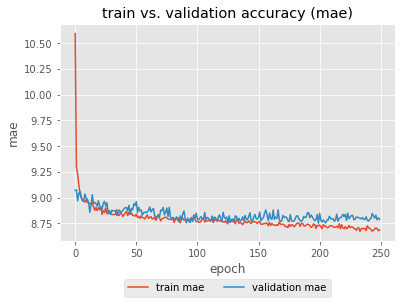

In [113]:
train_mae = history.history['mae']
valid_mae = history.history['val_mae'] 
#model.save('model_forecasting_seq2seq.h5')

plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [114]:
# predict
print('Predicting last reserved data point:')
print('True:     ', goldeny)
print('Predicted:', predict_one( model, goldenx ))

Predicting last reserved data point:
True:      [25 27 20 17]
Predicted: [[17.]
 [19.]
 [17.]
 [16.]]


In [115]:
def predict_on_trainset( model, X_, y_ ):
    
    for feature_set, target in zip( X_, y_ ):
        print('True:     ', target)
        print('Predicted:', predict_one( model, feature_set ), '\n', '='*28, sep='')
                
        
# evaluate
print('Evaluating on train set...')
score = model.evaluate( X, y, verbose=1 )
print('\nTrain: ', score[0])
print('Train MSE:    ', score[1])

# predict
m = 100
print(f'Predicting on last {m} rows of train set:\n')
predict_on_trainset( model, X[-m:], y[-m:] )

Evaluating on train set...
65/65 [==============================] - 1s 10ms/step - loss: 100.1655 - mae: 8.6465

Train:  100.16551208496094
Train MSE:     8.646524429321289
Predicting on last 100 rows of train set:

True:      [19  5  4 28]
Predicted:[[19.]
 [16.]
 [18.]
 [17.]]
True:      [33 22  3 30]
Predicted:[[18.]
 [16.]
 [16.]
 [16.]]
True:      [23  2 18  3]
Predicted:[[17.]
 [14.]
 [15.]
 [15.]]
True:      [23  1 15 29]
Predicted:[[17.]
 [19.]
 [17.]
 [17.]]
True:      [10  7 18 33]
Predicted:[[18.]
 [19.]
 [18.]
 [18.]]
True:      [18 13  4 35]
Predicted:[[18.]
 [18.]
 [17.]
 [17.]]
True:      [27 11 13 32]
Predicted:[[18.]
 [17.]
 [17.]
 [17.]]
True:      [19 23  5 28]
Predicted:[[18.]
 [18.]
 [17.]
 [16.]]
True:      [23 24 17 34]
Predicted:[[18.]
 [16.]
 [16.]
 [17.]]
True:      [30 26  8 20]
Predicted:[[18.]
 [17.]
 [16.]
 [16.]]
True:      [ 8 30 11  3]
Predicted:[[17.]
 [17.]
 [17.]
 [17.]]
True:      [ 6 12 19  5]
Predicted:[[16.]
 [18.]
 [18.]
 [19.]]
True:      [31 1

Predicted:[[17.]
 [17.]
 [17.]
 [16.]]
True:      [26 25 18 23]
Predicted:[[17.]
 [16.]
 [17.]
 [16.]]
True:      [10 14  6  1]
Predicted:[[16.]
 [16.]
 [17.]
 [17.]]
True:      [18 26 11 30]
Predicted:[[16.]
 [17.]
 [16.]
 [16.]]
True:      [19  9 22  5]
Predicted:[[18.]
 [17.]
 [18.]
 [17.]]
True:      [25 35  7 30]
Predicted:[[18.]
 [18.]
 [18.]
 [17.]]
True:      [13  2 26 24]
Predicted:[[18.]
 [16.]
 [18.]
 [17.]]
True:      [ 3 15 22 30]
Predicted:[[20.]
 [19.]
 [19.]
 [18.]]
True:      [30  3 11 19]
Predicted:[[20.]
 [19.]
 [19.]
 [18.]]
True:      [28  6  3 30]
Predicted:[[20.]
 [19.]
 [18.]
 [17.]]
True:      [ 8  9 28  3]
Predicted:[[19.]
 [18.]
 [16.]
 [16.]]
True:      [34 15 12 27]
Predicted:[[19.]
 [20.]
 [18.]
 [18.]]
True:      [ 7 29 22 26]
Predicted:[[18.]
 [18.]
 [17.]
 [17.]]
True:      [32  4 30  3]
Predicted:[[16.]
 [17.]
 [17.]
 [17.]]


In [116]:
unknown_variable

NameError: name 'unknown_variable' is not defined

# Appendix. Code from DL notebook

## Fit model & plot results

In [ ]:
# Keras LR Schedules: https://keras.io/api/optimizers/learning_rate_schedules/
# KERAS WAY TO DEFINE LR SCHEDULES
#initial_learning_rate = 0.001
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(   initial_learning_rate,
#                                                                decay_steps=500,         # 1 epoch = 50 steps
#                                                                decay_rate=0.96,
#                                                                staircase=True )

#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

#model.fit(data, labels, epochs=5)

In [ ]:
# YOUR WAY TO DEFINE LR DECAY
import math
def step_decay(epoch):
    
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        
    return lrate


def exponential_decay(epoch):
    
    initial_lrate = 1.0
    k = 0.7
    lrate = initial_lrate * math.exp(-k*epoch)
        
    return lrate

# USAGE
#if use_lr_decay:
#    lrate = LearningRateScheduler( step_decay )
#    callbacks = [lrate]
#else:
#    callbacks = []
#model.fit( ... callbacks=callbacks )

for i in range(10):
    print( step_decay(i) )

In [ ]:
# loss:        mse, mae, huber, logcosh    (mape, msle - maximize mse; need input data scaling?)
# optimizers: SGD, RMSprop, Adagrad, Adadelta, Adamax, Adam, Nadam, Ftrl
# metrics:    metric_mse, metric_rmse, metric_mae, metric_mape, metric_msle, metric_lcosh

# model parameters
initial_learning_rate  = 0.001
units         = 40
dropout1      = 0.075
dropout2      = 0
dropout3      = 0
loss          = mse
optimizer     = Adamax
use_time_series = True
use_lr_decay  = False
metrics       = [ metric_lcosh, metric_mae, metric_msle, ]

# if lr decay - Keras API
if use_lr_decay:    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(   initial_learning_rate,
                                                                    decay_steps=500,       # 1 epoch = 50 steps
                                                                    decay_rate=0.96,
                                                                    staircase=True )
    learning_rate_to_model = lr_schedule
else:
    learning_rate_to_model = initial_learning_rate

# initiate model
model_name = 'multi_stacked_LSTM'                                      # used further in plots
model = multi_stacked_LSTM( n_steps, n_features,
                        learning_rate_ = learning_rate_to_model,
                        units = units,
                        dropout1 = dropout1,
                        dropout2 = dropout2,
                        dropout3 = dropout3,
                        loss=loss,
                        optimizer=optimizer,
                        use_lr_decay=use_lr_decay,
                        metrics=metrics,
                      )

# use unshuffled (time series) or shuffled data
if use_time_series:
    X_train = X
    y_train = y
else:
    X_train = X_sh
    y_train = y_sh
do_shuffle = not use_time_series                                   # shuffling while fitting

# model fit paramaters
batch_size = 32
epochs     = 250
verbose    = 1

# learning rate & early stopping
lrate = LearningRateScheduler( step_decay )
callbacks = [ EarlyStopping( monitor='loss',
                             min_delta=0.001,
                             patience=20,
                             verbose=verbose,
                             restore_best_weights=True,          # restore from the best previous epoch
                             mode='min'                         #(stops decreaqsing) or 'max'; default 'auto'
                           ),
#              lrate,
            ]
                          
# fit model
history = model.fit( X_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     shuffle=do_shuffle,
                     verbose=verbose,
                     validation_split=0.25,
                     callbacks=callbacks, )                      #see lr_schedule w/optimizer above for lr_decay

In [ ]:
# PLOT RESULTS (Note: ncols & nrows are constant values for all subplots)
optimizer_name = model.optimizer.get_config()['name']
loss_func_name = model.loss.get_config()['name']
metric_names   = [ i.get_config()['name'] for i in model.metrics if i.get_config()['name'] != 'loss']
features_list  = ', '.join(features)

ncols = 2
nrows = (len(metric_names) + 1) // ncols
figure_width  = 15
figure_height = nrows*0.75*(15/ncols) - 0.5
plt.subplots(nrows, ncols, figsize=(figure_width, figure_height))
joint_title = model_name + f' (batch_size {batch_size}, epochs {epochs}, loss {loss_func_name}, ' +\
              f'lr {initial_learning_rate}, units {units}, optimizer {optimizer_name},\nn_steps {n_steps}, ' +\
              f'n_features {n_features}, dropout1={dropout1}, dropout2={dropout2}, dropout3={dropout3},\n' +\
              f'use_time_series={use_time_series}, with_intersection={with_intersection}, ' +\
              f'flatten={flatten}, random_state={random_state},\nfeatures: {features_list})'
                
plt.suptitle( joint_title, fontsize=14 )

# remove very large values in the beginning
start_value = 2

plt.subplot(nrows, ncols, 1)
plt.plot(history.history['loss'][start_value:])
plt.plot(history.history['val_loss'][start_value:])
plt.ylabel(loss_func_name + ' loss')
plt.xlabel('epochs')
plt.legend(['train','val'], loc='upper right')
#plt.show()

for idx, metric_name in enumerate(metric_names):
    plt.subplot(nrows, ncols, idx+2)
    plt.plot(history.history[metric_name][start_value:])
    plt.plot(history.history['val_' + metric_name][start_value:])
    plt.ylabel(metric_name)
    plt.xlabel('epochs')
    plt.legend(['train','val'], loc='upper right')
        
plt.tight_layout()

# save figure
if use_time_series:
    ts_indicator = '_TS_'
else:
    ts_indicator = '_Shuffle_'
timestr   = time.strftime('%Y%m%d-%H%M%S')
folder    = './plots/'
file_name = folder + model_name + '_' + loss_func_name.capitalize() + '_' + optimizer_name + '_' + str(epochs) + '_Epochs' + ts_indicator + timestr + '.jpeg'
plt.savefig(file_name)
 
plt.show()

In [ ]:
print( min(history.history['val_loss']) )
min_val = min(history.history['val_loss'])
print(history.history['val_loss'].index(min_val))

In [ ]:
timestr   = time.strftime('%Y%m%d-%H%M%S')
folder    = './models/'
file_name = folder + timestr + '_' + model_name + '_' + loss_func_name.capitalize() + '_' + optimizer_name + '_' + str(epochs) + '_Epochs' + ts_indicator + str(n_steps) + 'n_steps' + '.h5'
model.save(file_name)

# LOAD MODEL
#from keras.models import load_model
#del model
#model = load_model('my_model.h5')

## Predict on last reserved data point and partial train set

In [ ]:
# predict
print('Predicting last reserved data point:')
print('True:     ', goldeny)
print('Predicted:', predict_one( model, goldenx ))

In [ ]:
# EVALUATE AND PREDICT ON TRAIN SET
def predict_on_trainset( model, X_, y_ ):
    
    for feature_set, target in zip( X_, y_ ):
        print('True:     ', target)
        print('Predicted:', predict_one( model, feature_set ), '\n', '='*28, sep='')
                
        
# evaluate
print('Evaluating on train set...')
score = model.evaluate( X_train, y_train, verbose=verbose )
print('\nTrain ' + loss_func_name.capitalize() + ':', score[0])
print('Train MSE:    ', score[1], '\n\n', '='*100, '\n', sep='')

# predict
m = 100
print(f'Predicting on last {m} rows of train set:\n')
predict_on_trainset( model, X_train[-m:], y_train[-m:] )

In [ ]:
import gc
gc.collect()

# Appendix

__OPTIMIZERS. IMPORTED TO BE CALLABLE ( Adam(lr=learning_rate) )__  
Using the code below does not make them callable. Each optimizer has also `**kwargs` as a parameter:
* `SGD = tf.keras.optimizers.SGD( learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD" )    # old`
* `RMSprop = tf.keras.optimizers.RMSprop( learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name="RMSprop" )`
* `Adagrad = tf.keras.optimizers.Adagrad( learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07,name="Adagrad" )`
* `Adadelta = tf.keras.optimizers.Adadelta( learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta" )`
* `Adamax = tf.keras.optimizers.Adamax( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax" )`
* `Adam = tf.keras.optimizers.Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam" )`
* `Nadam = tf.keras.optimizers.Nadam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam" )`
* `Ftrl = tf.keras.optimizers.Ftrl( learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0, name="Ftrl", l2_shrinkage_regularization_strength=0.0 )`